### Requirements

In [ ]:
!pip install torchvision -q

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import itertools
import numpy as np
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

# Path to achitecture .py file
project_path = '/content/drive/MyDrive/STAT 542 Project'


# Add the path to sys.path
if project_path not in sys.path:
    sys.path.append(project_path)

In [ ]:
!ls "/content/drive/My Drive/STAT 542 Project"

 bird_classification_pytorch.ipynb   ResNet_pytorch.py
 fashion_mnist_pytorch.ipynb	     SimpleBC_MNIST.ipynb
 __pycache__			    'STAT 542 Final Project .gdoc'


### Import ResNet Functions

In [ ]:
try:
    from ResNet_pytorch import resnet18
    print("Successfully imported ResNet_pytorch.py")
except ImportError:
    print("Error: Could not import ResNet_pytorch.py.")
    print("Please make sure 'ResNet_pytorch.py' is in the same directory.")
    exit()

Successfully imported ResNet_pytorch.py


### SetUp

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Hyperparameter

In [ ]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = 10      # FashionMNIST has 10 classes
INPUT_CHANNELS = 1    # FashionMNIST is grayscale

### Normalization

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize(224), # ResNet-18 standard input size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5], # Grayscale mean
        std=[0.5]   # Grayscale std
    ),
])

### Load Dataset

In [ ]:
# Training
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=image_transforms
)
# Testing
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=image_transforms
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


### Data Loader

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

### Model Initialization

In [ ]:
model = resnet18(num_classes=NUM_CLASSES)

model.conv1 = nn.Conv2d(
    INPUT_CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model = resnet18(num_classes=NUM_CLASSES)

model.conv1 = nn.Conv2d(INPUT_CHANNELS, 64, kernel_size=3, stride=1, padding=1, bias=False) # ResNet-9
model.maxpool = nn.Identity()

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
NUM_EPOCHS = 100
BATCH_SIZE = 32

### Model Setup

In [ ]:
train_losses = []
test_losses = []
test_accuracies = []

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """Handles the training process and evaluates after each epoch, tracking losses."""
    model.train()
    print("\nStarting training on FashionMNIST...")

    # Clear logs before starting
    train_losses.clear()
    test_accuracies.clear()
    test_losses.clear()

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate and Save Training Loss
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Run Evaluation to get Test Loss and Accuracy
        acc, test_loss = evaluate_model(model, test_loader, criterion, device)

        # Save Test Loss and Accuracy
        test_losses.append(test_loss)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1} finished. Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {acc:.2f}%")

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    """Calculates the Top-1 accuracy AND the average test loss."""
    model.eval()
    correct_predictions = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader: # simplified access for FashionMNIST
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss

            total_loss += loss.item() * labels.size(0) # Accumulate weighted loss

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_samples
    avg_loss = total_loss / total_samples # Calculate average loss

    return accuracy, avg_loss

### Model Training

In [ ]:
train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)


Starting training on FashionMNIST...


Epoch 1/100: 100%|██████████| 1875/1875 [36:44<00:00,  1.18s/it]


Epoch 1 finished. Train Loss: 2.1200 | Test Loss: 1.9485 | Test Accuracy: 45.15%


Epoch 2/100: 100%|██████████| 1875/1875 [35:26<00:00,  1.13s/it]


Epoch 2 finished. Train Loss: 1.5878 | Test Loss: 1.2475 | Test Accuracy: 59.27%


Epoch 3/100: 100%|██████████| 1875/1875 [35:25<00:00,  1.13s/it]


Epoch 3 finished. Train Loss: 1.0797 | Test Loss: 0.9427 | Test Accuracy: 68.30%


Epoch 4/100: 100%|██████████| 1875/1875 [35:25<00:00,  1.13s/it]


Epoch 4 finished. Train Loss: 0.8998 | Test Loss: 0.8392 | Test Accuracy: 71.36%


Epoch 5/100: 100%|██████████| 1875/1875 [35:24<00:00,  1.13s/it]


Epoch 5 finished. Train Loss: 0.8026 | Test Loss: 0.8467 | Test Accuracy: 70.43%


Epoch 6/100: 100%|██████████| 1875/1875 [35:25<00:00,  1.13s/it]


Epoch 6 finished. Train Loss: 0.7326 | Test Loss: 0.7179 | Test Accuracy: 75.05%


Epoch 7/100: 100%|██████████| 1875/1875 [35:26<00:00,  1.13s/it]


Epoch 7 finished. Train Loss: 0.6787 | Test Loss: 0.6472 | Test Accuracy: 77.92%


Epoch 8/100:  58%|█████▊    | 1089/1875 [20:34<14:50,  1.13s/it]

### Implement Learning Rate Schedule and Weight Decay

In [ ]:
WEIGHT_DECAY = 1e-3
STEP_SIZE = 3   # Reduce LR every 3 epochs
NUM_EPOCHS = 6
GAMMA = 0.1

In [ ]:
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY  # Applies L2 Regularization
)

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA
)

In [ ]:
model = resnet18(num_classes=NUM_CLASSES)

model.conv1 = nn.Conv2d(
    INPUT_CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_model_scheduled(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Handles the training process with LR scheduling and evaluates after each epoch."""
    model.train()
    print("\nStarting Scheduled Training on FashionMNIST...")

    # Clear logs before starting (assuming global lists)
    train_losses.clear()
    test_losses.clear()
    test_accuracies.clear()

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()
        print(f"LR updated. New LR: {optimizer.param_groups[0]['lr']:.8f}")

        # Calculate and Save Training Loss
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Run Evaluation to get Test Loss and Accuracy
        acc, test_loss = evaluate_model(model, test_loader, criterion, device)

        # Save Test Loss and Accuracy
        test_losses.append(test_loss)
        test_accuracies.append(acc)

        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {acc:.2f}% | Time: {end_time - start_time:.2f}s")

    print("\nTraining complete.")

In [ ]:
train_model_scheduled(model, train_loader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)


Starting Scheduled Training on FashionMNIST...


Epoch 1/6: 100%|██████████| 1875/1875 [02:58<00:00, 10.52it/s]

LR updated. New LR: 0.00001000


Epoch 1 finished. Train Loss: 0.6187 | Test Loss: 0.3815 | Test Accuracy: 86.41% | Time: 189.42s


Epoch 2/6: 100%|██████████| 1875/1875 [02:56<00:00, 10.65it/s]

LR updated. New LR: 0.00001000


Epoch 2 finished. Train Loss: 0.3519 | Test Loss: 0.3591 | Test Accuracy: 87.39% | Time: 187.10s


Epoch 3/6: 100%|██████████| 1875/1875 [02:56<00:00, 10.62it/s]

LR updated. New LR: 0.00001000


Epoch 3 finished. Train Loss: 0.2966 | Test Loss: 0.3281 | Test Accuracy: 87.91% | Time: 187.51s


Epoch 4/6: 100%|██████████| 1875/1875 [02:56<00:00, 10.63it/s]

LR updated. New LR: 0.00001000


Epoch 4 finished. Train Loss: 0.2703 | Test Loss: 0.2900 | Test Accuracy: 89.47% | Time: 187.43s


Epoch 5/6: 100%|██████████| 1875/1875 [02:56<00:00, 10.62it/s]

LR updated. New LR: 0.00001000


Epoch 5 finished. Train Loss: 0.2450 | Test Loss: 0.2769 | Test Accuracy: 90.18% | Time: 187.50s


Epoch 6/6: 100%|██████████| 1875/1875 [02:56<00:00, 10.63it/s]

LR updated. New LR: 0.00001000


Epoch 6 finished. Train Loss: 0.2247 | Test Loss: 0.2803 | Test Accuracy: 90.16% | Time: 187.36s

Training complete.


### Loss Comparison

In [ ]:
def plot_training_results(train_losses, test_losses, accuracies, num_epochs):
    """Plots the training/test losses on one figure and test accuracy on another."""
    epochs = np.arange(1, num_epochs + 1)

    # Plot Loss Comparison (Training vs. Test)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker='x', color='red', linestyle='--')

    plt.title('Loss Comparison Over Epochs (FashionMNIST)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (CrossEntropy)')
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.savefig('fashion_mnist_loss_comparison.png')
    plt.show()
    plt.close()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, accuracies, label='Test Accuracy', marker='o', color='green')
    plt.title('Test Accuracy Over Epochs (FashionMNIST)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.savefig('fashion_mnist_test_accuracy.png')
    plt.show()
    plt.close()

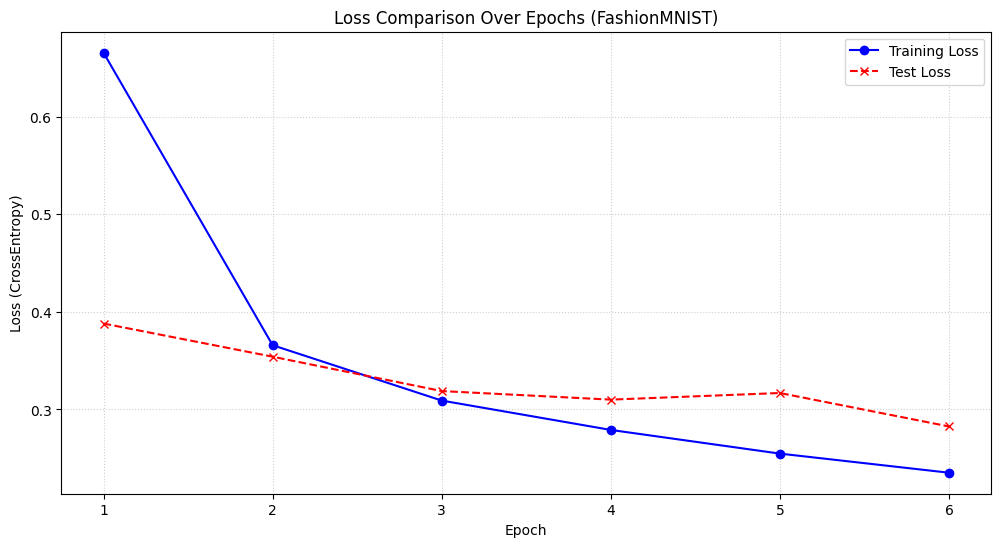

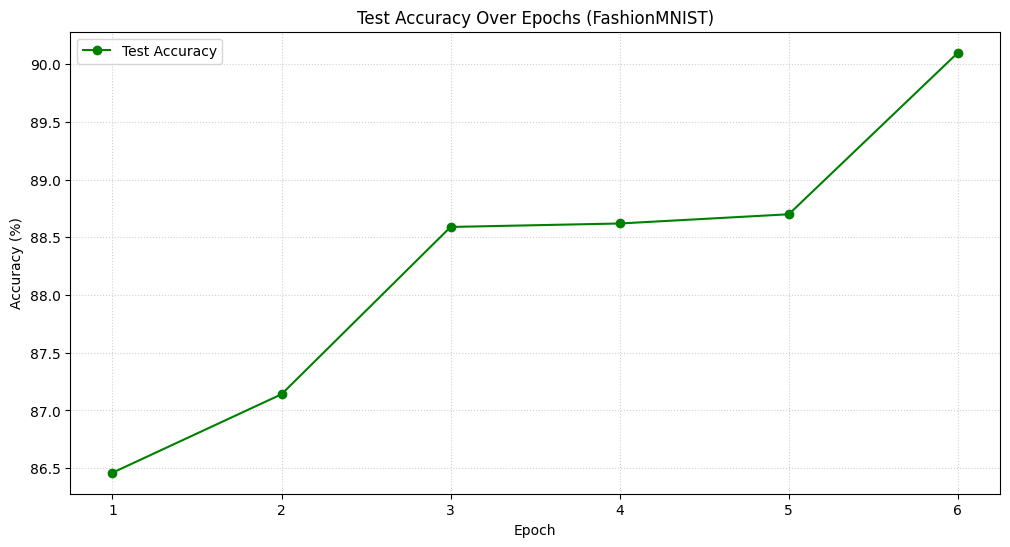

In [ ]:
plot_training_results(train_losses, test_losses, test_accuracies, NUM_EPOCHS)